## Resizing and Masking the original dataset

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Data inspection

In [6]:
import os
folder_path = r'C:\Users\Thoma\Downloads\Python\COVID-19_Radiography_Dataset'
files = os.listdir(folder_path)  # List all files and folders
print(files)

['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [7]:
# We read in all file names of the data set into dictionaries

folder_covid = folder_path + '/COVID'
folder_normal = folder_path + '/Normal'
folder_lung_opacity = folder_path + '/Lung_Opacity'
folder_viral_pneumonia = folder_path + '/Viral Pneumonia'

sub_image = '/images'
sub_mask = '/masks'

# This definition, we will need often
image_classes = ['covid', 'lung_opacity', 'viral_pneumonia', 'normal']

folder_dict = {image_classes[0]: folder_covid, 
               image_classes[1]: folder_lung_opacity, 
               image_classes[2]: folder_viral_pneumonia, 
               image_classes[3]: folder_normal}

images_files_dict = {}
masks_files_dict = {}

for key, folder in folder_dict.items():
    print('Reading file_names of class:', key)
    images_files_dict[key] = np.sort(os.listdir(folder + sub_image))
    masks_files_dict[key] = np.sort(os.listdir(folder + sub_mask))

print('Images:', images_files_dict)
print('Masks:', masks_files_dict)


Reading file_names of class: covid
Reading file_names of class: lung_opacity
Reading file_names of class: viral_pneumonia
Reading file_names of class: normal
Images: {'covid': array(['COVID-1.png', 'COVID-10.png', 'COVID-100.png', ...,
       'COVID-997.png', 'COVID-998.png', 'COVID-999.png'], dtype='<U14'), 'lung_opacity': array(['Lung_Opacity-1.png', 'Lung_Opacity-10.png',
       'Lung_Opacity-100.png', ..., 'Lung_Opacity-997.png',
       'Lung_Opacity-998.png', 'Lung_Opacity-999.png'], dtype='<U21'), 'viral_pneumonia': array(['Viral Pneumonia-1.png', 'Viral Pneumonia-10.png',
       'Viral Pneumonia-100.png', ..., 'Viral Pneumonia-997.png',
       'Viral Pneumonia-998.png', 'Viral Pneumonia-999.png'], dtype='<U24'), 'normal': array(['Normal-1.png', 'Normal-10.png', 'Normal-100.png', ...,
       'Normal-9997.png', 'Normal-9998.png', 'Normal-9999.png'],
      dtype='<U16')}
Masks: {'covid': array(['COVID-1.png', 'COVID-10.png', 'COVID-100.png', ...,
       'COVID-997.png', 'COVID-998.

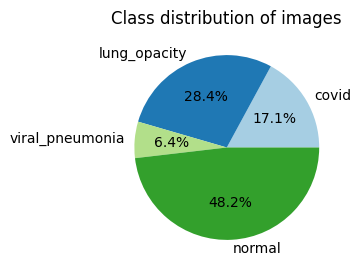

In [8]:
# Show the distribution of classes
plt.figure(figsize=(3,3))
plt.pie([len(value) for value in images_files_dict.values()], labels=images_files_dict.keys(), colors=plt.cm.Paired.colors, autopct='%1.1f%%')
plt.title('Class distribution of images')
plt.show()

In [9]:
test_image = cv2.imread(folder_dict[image_classes[0]] + sub_image + '/' + images_files_dict[image_classes[0]][0], cv2.IMREAD_GRAYSCALE) 
test_mask = cv2.imread(folder_dict[image_classes[0]] + sub_mask + '/' + masks_files_dict[image_classes[0]][0], cv2.IMREAD_GRAYSCALE) 
print(test_image.shape)
print(test_mask.shape)

# we use these 2 shapes to check, if all other images have the same shape
image_shape = test_image.shape
mask_shape = test_mask.shape

(299, 299)
(256, 256)


In [10]:
# Test for sizes of images
wrong_images = 0
wrong_masks = 0

for image_class in image_classes:
    for image_file_name, mask_file_name in zip(images_files_dict[image_class], masks_files_dict[image_class]):
        image = cv2.imread(folder_dict[image_class] + sub_image + '/' + image_file_name, cv2.IMREAD_GRAYSCALE) 
        if image_shape != image.shape:
            wrong_images += 1
            print(f"File {image_file_name} has other dimensions as {image_shape}")
        mask = cv2.imread(folder_dict[image_class] + sub_mask + '/' + mask_file_name, cv2.IMREAD_GRAYSCALE) 
        if mask_shape != mask.shape:
            wrong_masks += 1
            print(f"File {mask_file_name} has other dimensions as {mask_shape}")

print('Number of wrong images:', wrong_images)
print('Number of wrong masks:', wrong_masks)

# Nice, the only shapes we have is
# (299,299) for x-ray-images
# (256,256) for masks

Number of wrong images: 0
Number of wrong masks: 0


### Masking

([], [])

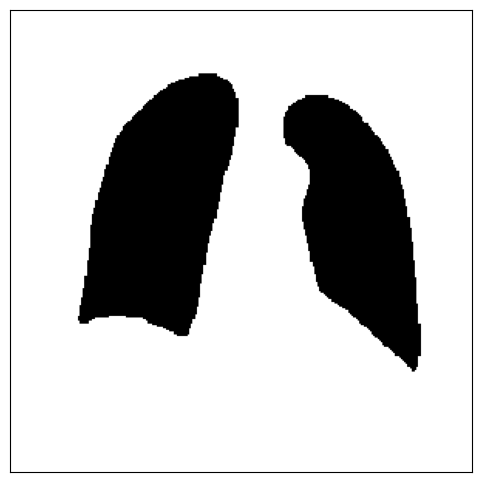

In [11]:
# Let's try to resize a shape to 299x299 and apply a mask, we use the test image and mask from above
resized_mask = cv2.resize(test_mask, image_shape, interpolation=cv2.INTER_NEAREST)

plt.figure(figsize = (6,6))
plt.imshow(resized_mask, cmap='binary')
plt.xticks([])
plt.yticks([])

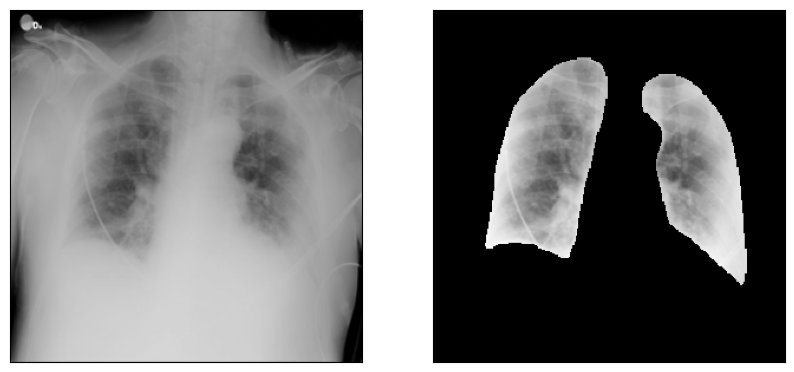

In [12]:
# Let's combine the mask with the test image
masked_image = cv2.bitwise_and(test_image, resized_mask)

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.imshow(test_image, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(masked_image, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.show()

# Looks good, let apply this to all other images

In [13]:
# Masked image creation
dataset_folder = '../dataset' # We store the masked files in this dataset folder for later use

for image_class in image_classes:
    print('Creating masked images for class:', image_class)
    for image_file_name, mask_file_name in zip(images_files_dict[image_class], masks_files_dict[image_class]):
        
        # Read in the image and the mask
        image_pathname = folder_dict[image_class] + sub_image + '/' + image_file_name
        image = cv2.imread(image_pathname, cv2.IMREAD_GRAYSCALE) 

        mask_pathname = folder_dict[image_class] + sub_mask + '/' + mask_file_name
        mask = cv2.imread(mask_pathname, cv2.IMREAD_GRAYSCALE) 
        
        # Resize the mask
        resized_mask = cv2.resize(mask, image_shape, interpolation=cv2.INTER_NEAREST)

        # Mask the image
        masked_image = cv2.bitwise_and(image, resized_mask)

        # Ensure the folder exists
        output_folder = dataset_folder + '/' + image_class
        os.makedirs(output_folder, exist_ok=True)

        # Save the masked image
        save_pathname = output_folder + '/' + image_file_name
        cv2.imwrite(save_pathname, masked_image)

Creating masked images for class: covid
Creating masked images for class: lung_opacity
Creating masked images for class: viral_pneumonia
Creating masked images for class: normal


### Data (images) Inspection

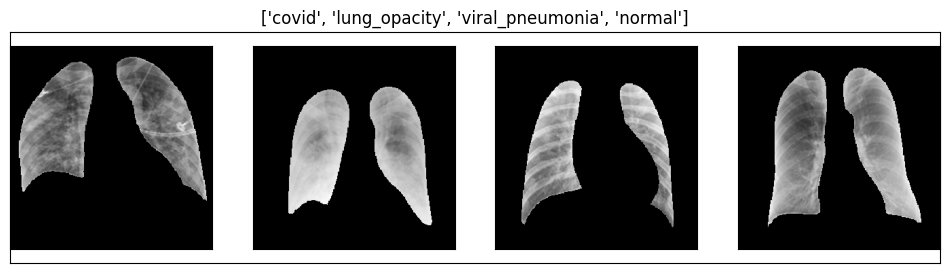

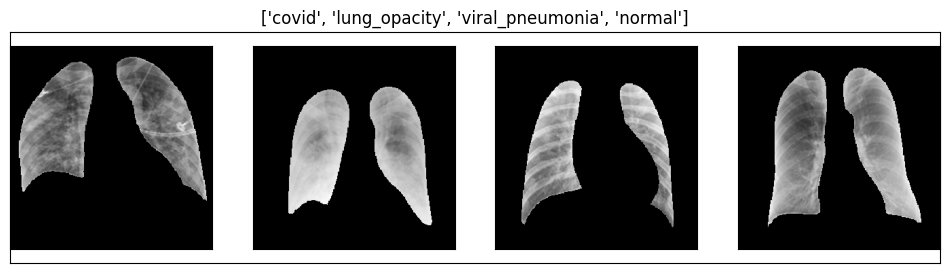

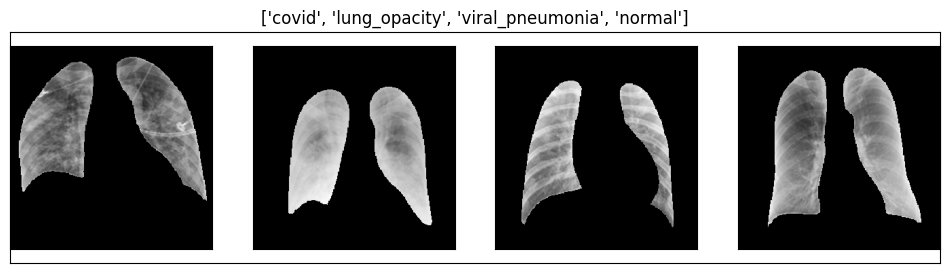

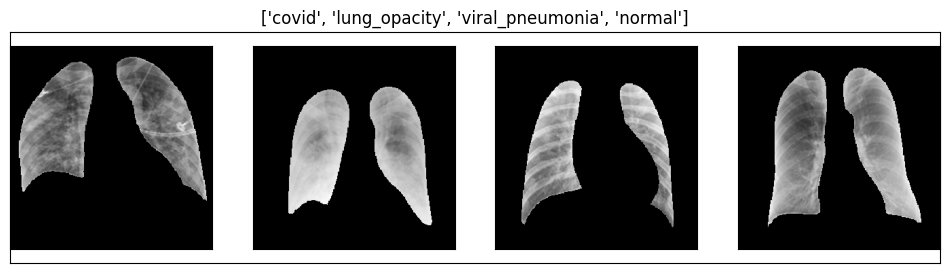

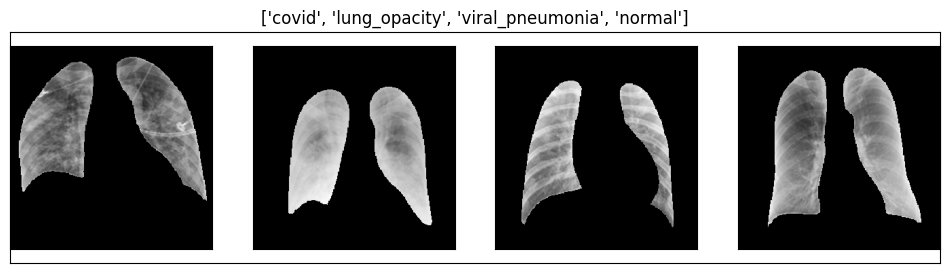

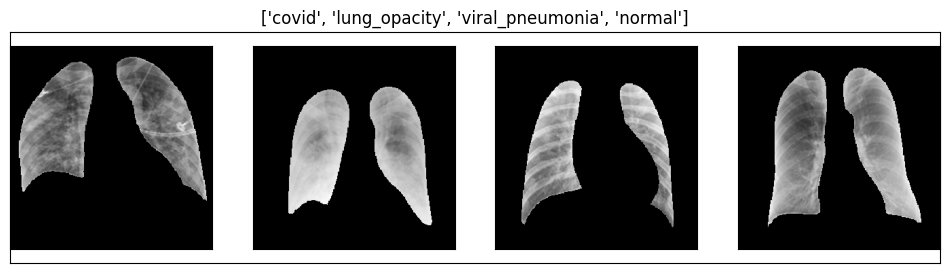

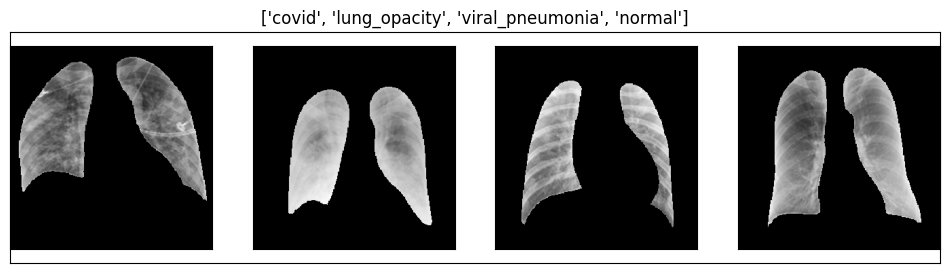

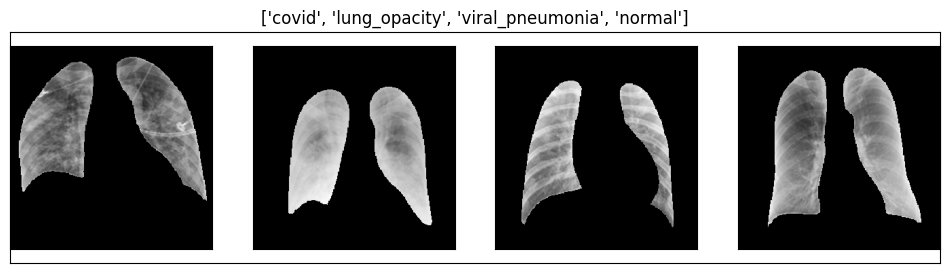

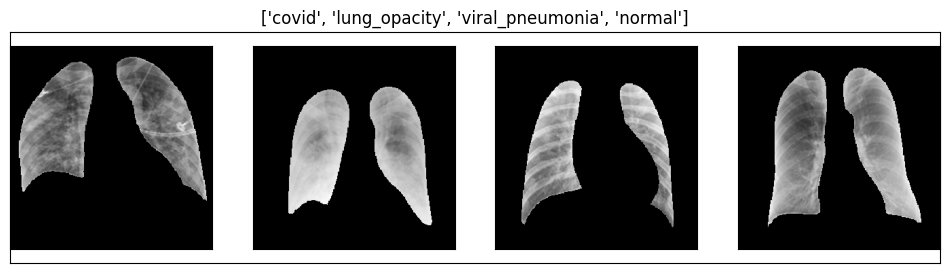

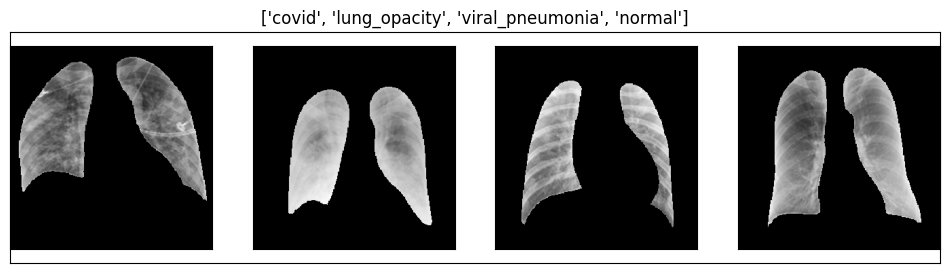

In [14]:
# Since we used the same filename, the list of masked filenames is the same as the images
# masked_images_files_dict = images_files_dict.copy()

# Reload and prepare some vars, so we can run this cell always without the previous
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

dataset_folder = '../dataset' # We store the masked files in this dataset folder for later use
image_classes = ['covid', 'lung_opacity', 'viral_pneumonia', 'normal']
masked_images_files_dict = {}
for image_class in image_classes:
    masked_images_files_dict[image_class] = np.sort(os.listdir(dataset_folder + '/' + image_class))
    
# Randomly show 10 images each from each category of the generated masked images side by side
nr_random = 10
random_files_dict = {}
for image_class in image_classes:
    # Selecting a choice of random file names
    random_files_dict[image_class] = np.random.choice(masked_images_files_dict[image_class], nr_random)

for i in range(nr_random):

    # We plot all 4 categories side by side for visual inspection
    plt.figure(figsize=(12,3))
    plt.title(str(image_classes[:]))
    plt.xticks([])
    plt.yticks([])

    for index, (image_class, file_names) in enumerate(random_files_dict.items()):
        
        # Read in the masked image
        image_pathname = dataset_folder + '/' + image_class + '/' + file_names[index]
        image = cv2.imread(image_pathname, cv2.IMREAD_GRAYSCALE) 

        plt.subplot(1,4,index+1)
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.show()